The Hamiltonian for a system of an electron and a proton is:

$$\hat{H}_{total} = -\frac{\hbar^2}{2m_p}\nabla^2_p + -\frac{\hbar^2}{2m_e}\nabla^2_e + \frac{e^2}{4 \pi \varepsilon_0 |\vec{r}_1 - \vec{r}_2|}$$

# Eigenstates of the System
Which we will, of course, put in the Time-Independent Schrodinger Equation:

$$\hat{H} \Psi(\vec{r}_1, \vec{r}_2, t) = E \Psi(\vec{r}_1, \vec{r}_2, t)\\
%\implies E_k \Psi_k(\vec{r}_1, \vec{r}_2, t) = \hat{H} \Psi_k(\vec{r}_1, \vec{r}_2, t)$$

However, we will simplify the situation first. The first thing you might have noticed is that for a two-particle system, the wavefunction depends on two coordinates, and this in fact extends the interpretation of $\Psi^2$ for a one-particle system (which was just the propability amplitude for finding the particle at that particular position), to being "the probability of finding particle 1 at $\vec{r}_1$ and particle 2 at $\vec{r_2}$". This is clearly something interesting, but we'll ignore two particle wavefunctions for now and focus on converting our problem to that of a one-particle wavefunction.

Another problem with two or more particles being simulated is that the Schrodinger equation just does not take spin into account, and spin is quite important for simulating multiparticle systems. We can't even simulate the hydrogen molecule $\text{H}_2$ without spin; the Schrodinger equation - if spin is not incorporated - predicts that hydrogen molecules can't exist (!) due to the fermionic interaction between the two atomic electrons. Specifically, the second electron is stuck in the higher energy non-bonding orbital $\sigma^\ast_{1s}$, and thus there is minimal energy change from the free atom case.

We apply the coordinate transformation to center of mass of coordinates, upon which we get the following Hamiltonian:

$$\hat{H}_{\text{CoM}}= -\frac{\hbar^2}{2\mu}\nabla_R^2-\frac{\hbar^2}{2\mu}\nabla_r^2 - \frac{e^2}{4 \pi \varepsilon_0 |\vec{r}|}$$

Where $\mu = \frac{m_p m_e}{m_p + m_e}$, $\vec{R} = \frac{m_e \vec{r_e} + m_p \vec{r_p}}{m_e + m_p}$ are the CoM coordiantes, and $\vec{r} = \vec{r_e} - \vec{r_p}$ is the displacement vector from one particle to the other. Either sign works. Refer to CH107 from first year for the details. Thus our Hamiltonian is separated into free-particle Hamiltonian on the COM and a one-particle Hamiltonian in a Coulombic potential. We are interested in the second part.

## Question 1
Expand the second part of the Hamiltonian, the one acting on the displacement vector $\vec{r} = (x,y,z)$, in Cartesian coordinates.

$$
\hat{H} = -\frac{\hbar^2}{2\mu} \left( \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} + \frac{\partial^2}{\partial z^2} \right) - \frac{e^2}{4\pi\epsilon_0 \sqrt{x^2 + y^2 + z^2}}.
$$

# Numerical Solution
Here's how we are going to solve this numerically:

Using the finite-difference method, we discretize the left side of the equation so that the partial derivative terms get converted into terms involving the value of $\psi$ at a coordinate _and_ its neighoring coordinates.

## Question 2
Discretize the Schrodinger Equation using Cartesian coordinates. Consider a spacing between the points of $\Delta x$ for all axes.

We can actually use this discretized form of the right hand side to compute the energy eigenstates and eigenvalues of the electron in this hydrogen atom model, which should give us the familiar orbitals of a hydrogen atom. Let's try that first!

All we need to do is to construct the Hamiltonian matrix by first flattening the possible coordinates of psi and then constructing the operator matrix that gives us the left hand side of the equation. Then we use an eigensolver algorithm for the operator matrix to obtain the eigenvectors and eigenvalues.

Step 1 : Let us create the Hamiltonian operator and all the other tools we will need.

In [ ]:
#importing standard data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *

In [ ]:
from scipy.constants import hbar, e, m_e, m_p, epsilon_0, pi
from scipy.sparse import diags, csr_matrix

mu = m_e*m_p/(m_e+m_p)

L = 1e-9
N = 50
dx = L/N

x = np.linspace(-L/2, L/2, N)
y = np.linspace(-L/2, L/2, N)
z = np.linspace(-L/2, L/2, N)

X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
r = np.sqrt(X**2 + Y**2 + Z**2)
r[r==0] = dx/10
V = -e**2 / (4 * np.pi * epsilon_0 * r)
V_flat = V.flatten()
H_potential = diags(V_flat, 0, format="csr")

def laplacian_3d(n, m, l):
    S = n * m * l

    row_indices = []
    col_indices = []
    data = []

    for i in range(S):
        x, y, z = i % n, (i // n) % m, (i // (n * m)) % l

        row_indices.append(i)
        col_indices.append(i)
        data.append(-6)

        neighbors = [(x + 1, y, z), (x - 1, y, z), (x, y + 1, z), (x, y - 1, z), (x, y, z + 1), (x, y, z - 1)]
        for nx, ny, nz in neighbors:
            if 0 <= nx < n and 0 <= ny < m and 0 <= nz < l:
                j = nx + n * ny + n * m * nz
                row_indices.append(i)
                col_indices.append(j)
                data.append(1)

    laplacian = csr_matrix((data, (row_indices, col_indices)), shape=(S, S))
    return laplacian

H_kinetic = -hbar**2 / (2 * mu * (dx**2)) * laplacian_3d(N, N, N)

H = H_kinetic + H_potential

In [ ]:
from scipy.sparse.linalg import eigs

num_eigenvalues = 10
eigenvalues, eigenvectors = eigs(H, k=num_eigenvalues, which='SR')  # Smallest Real
eigenvalues = np.sort(np.real(eigenvalues))

print("Eigenvalues (energy levels):", eigenvalues/e)

Eigenvalues (energy levels): [-12.65914586  -3.17998642  -3.17998642  -3.17998642  -3.02066084
  -0.67794708  -0.67794708  -0.33588614  -0.33588614   0.33187595]


## Question 3: Constructing the Hamiltonian Operator
Recall the method of converting the discretized version of the laplacian operator into a 2D matrix, and apply the same technique for the discretized version of the hamiltonian operator. Construct the hamiltonian matrix within `get_hamiltonian`. Also fill in the helper functions `index3d_to_flat`, `flat_to_index3d`, and `index3d_to_coords`.

In [ ]:
import scipy.sparse as sp
from scipy.constants import hbar, e, m_e, m_p, epsilon_0, pi

#reduced mass
mu = m_e*m_p/(m_e+m_p)

N = 100
Delta_x = 2e-9/N # our boundary width is 1e-8 m

def index3d_to_flat(i,j,k):
    '''Write a function that converts the i,j,k integer coordinates of the unflattened psi array
       into the appropriate flattened index
    '''
    return int(i + N * j + N * N * k)

def flat_to_index3d(flat_index):
    '''Now write a function to do the reverse. Remember the limits on the coords
       i.e. 0 <= i,j,k < N. Base N if you prefer that.
    '''
    i = flat_index % N
    j = (flat_index // N) % N
    k = flat_index // (N * N)
    return i, j, k

def index3d_to_coords(i,j,k):
    '''Now we transform the coords to real space coordinate. Remember to incorporate
       the scaling factor
    '''
    x = (i - (N - 1) / 2) * Delta_x
    y = (j - (N - 1) / 2) * Delta_x
    z = (k - (N - 1) / 2) * Delta_x
    return x, y, z

# Define the position of the proton/central position, depends if you are taking
# an approximation point of view or proper CoM transformation
proton_position = index3d_to_coords((N - 1)/2.0, (N - 1)/2.0, (N - 1)/2.0)
# Or you can remove this and implicitly assume an appropriate position below

############################################################################################################################################################

hamiltonian = sp.lil_matrix((N**3, N**3), dtype=np.cfloat) # create a sparse matrix

def get_hamiltonian(matrix, N, Delta_x):
    T_factor = -(hbar**2)/(2*mu*(Delta_x**2)*e)
    V_factor = e/(4*pi*epsilon_0)
    '''Initialize the matrix elements appropriately.
       Since the matrix is going to be large, we have already taken it to be sparse.
       No need to set any 0 elements.
    '''
    for i in range(N):
        for j in range(N):
            for k in range(N):
                flat_index = index3d_to_flat(i, j, k)
                x, y, z = index3d_to_coords(i, j, k)

                r = np.sqrt(x**2 + y**2 + z**2)
                if r == 0: r = Delta_x / 10

                V = -V_factor / r

                matrix[flat_index, flat_index] = T_factor * (-6) + V
                neighbors = [(i + 1, j, k), (i - 1, j, k), (i, j + 1, k), (i, j - 1, k), (i, j, k + 1), (i, j, k - 1)]
                for ni, nj, nk in neighbors:
                    if 0 <= ni < N and 0 <= nj < N and 0 <= nk < N:
                        n_flat_index = index3d_to_flat(ni, nj, nk)
                        matrix[flat_index, n_flat_index] = T_factor

    return matrix

hamiltonian = get_hamiltonian(hamiltonian, N, Delta_x)

Ok, so what is the algorithm we are going to use? This is a procedure called _power iteration_.

Consider the eigenvalue problem $Ax = \lambda x$, with eigenpairs $(\lambda_i, x_i)$. For convenience we assume that $\lambda_1 > \lambda_2 > \cdots > \lambda_n$ (or atleast their absolute values, if we have complex eigenvalues). Let us have any random vector $b = x_1 + x_2 + \cdots + x_n$, for appropriately scaled $x_i$. Then we find that on repeat application of the matrix, $$\begin{align}
 b^{(0)} &= b & &= \phantom{\lambda_1} x_1 + \phantom{\lambda_2} x_2 + \cdots + \phantom{\lambda_n} x_n \\
 b^{(1)} &= Ab & &= \lambda_1 x_1 + \lambda_2 x_2 + \cdots + \lambda_n x_n \\
 b^{(2)} &= A^2b & &= \lambda_1^2 x_1 + \lambda_2^2 x_2 + \cdots + \lambda_n^2 x_n \\
 & &&\hspace{4em} \vdots \\
 b^{(k)} &= A^kb & &= \lambda_1^k x_1 + \lambda_2^k x_2 + \cdots + \lambda_n^k x_n \\
\end{align}$$
If we consider the most dominant factor in $b^{(k)}$, we find that clearly must be $\lambda_1^k x_1$, since $$b^{(k)} = \lambda_1^k \left( x_1 + \left(\frac{\lambda_2}{\lambda_1}\right)^k x_2 + \cdots + \left(\frac{\lambda_k}{\lambda_1}\right)^k x_n \right)$$
Since each factor for the other eigenvectors have absolute values less than 1 (because $|\lambda_1| > |\lambda_i| \forall i$), the multiplier trends of to 0. Note that this is a terrible way to take a limit, but it's fine for now.

Thus, if we had some way, any way, to rescale and normalize $b^{(k)}$, then it would trend to the eigenvector. Hurrah, 1 eigenvector extracted! Let's implement that.

Although while implementing the algortihm, you'll want to rescale $b^{(k)}$ at each step instead of just at the end. It will also make comparisions with previous iterations easier when determining convergence.

## Question 4: Implementing the Power Iteration Algorithm
Based on the theory provided above, implement the power iteration algorithm within the `power_iteration` function.

In [ ]:
def power_iteration(matrix, mu = 0, max_iterations = 1000, excluded_space = None, tolerance = 1e-8, x_0 = None):
    if x_0 is None:
        vector = np.random.rand(matrix.shape[0])
    else:
        vector = np.array(x_0)

    if np.all(vector == 0):
        vector = np.random.rand(matrix.shape[0])

    shifted_matrix = matrix - mu * sp.eye(matrix.shape[0])
    eigenvalue = 0

    for _ in range(max_iterations):
        vector_new = shifted_matrix @ vector
        eigenvalue_new = np.linalg.norm(vector_new)
        vector_new = vector_new / eigenvalue_new

        if np.abs(eigenvalue_new - eigenvalue) / np.abs(eigenvalue_new) < tolerance:
            break

        if excluded_space is not None:
            for excluded_vector in excluded_space:
                vector_new -= (np.dot(vector_new, excluded_vector) / np.dot(excluded_vector, excluded_vector)) * excluded_vector

        eigenvalue = eigenvalue_new
        vector = vector_new / np.linalg.norm(vector_new)

    return eigenvalue - mu, vector
    "returns the dominant eigenvalue and eigenvector of the matrix"


In [ ]:
# Get the one with max(abs) eigen value
e_val1, eig_vec1 = power_iteration(hamiltonian)
eigenvector_list = [eig_vec1]
eigenvalue_list = [e_val1]
print(e_val1, eig_vec1)

1140.4867892844416 [ 1.03711445e-06+0.j -2.06222983e-06+0.j  3.06377507e-06+0.j ...
  7.58327416e-07+0.j -5.44706974e-07+0.j  2.84241715e-07+0.j]


Yay, the code above should compute the eigenvector with largest (absolute) eigenvalue. Feel free to go ahead and visualize the eigenstate using the `plot_wavefunction_2dslice` function a few cells below. However, the eigenvalue is probably positive, and you will be disappointed by the plot. After all, the largest absolute eigenvalue need not be the ground state, it's a hydrogen atom in a _box_ after all. Positive energy states are expected.

So, how get at the ground state? Well, we can manipulate the eigenvalues of a matrix by adding matrices that are _similar_ to it([remember the linear algebra defintion](https://en.wikipedia.org/wiki/Matrix_similarity)), and the identity matrix is similar to everything. Thus we shift our eigenvalues by operating on the matrix $(A-\mu I)$ instead! If we choose $\mu$ to be the positive maximum eigenvalue we found, then the one we will obtain from computing $(A-\mu I)$ will the one which is farthest from the positive eigenvalue, the negative maximum eigenvalue, the ground state. Note that for our $A$, all eigenvalues are real since it's hermitian.

Go back and add the optional $\mu$ input variable (named `mu`) to the function `power_iteration`. For optimization, we suggest not creating a new matrix $M = A - \mu I$ but implementing it implicitly. Be sure to compensate for $\mu$ in the output eigenvalue if you do end up editing the matrix.

In [ ]:
# Get the other one and sort
e_val2, eig_vec2 = power_iteration(hamiltonian, mu = e_val1, max_iterations = 3000)
# Now technically we don't know which one was the maximum and which one was the minimum,
# just that they are bounds of the eigen values. So let's sort them.
min_e, max_e = (e_val1, e_val2) if e_val1.real < e_val2.real else (e_val2, e_val1)
min_vec, max_vec = (eig_vec1, eig_vec2) if e_val1.real < e_val2.real else (eig_vec2, eig_vec1)
# Technically the order doesn't matter here, but we are doing this for later convenience
eigenvector_list = [max_vec, min_vec]
eigenvalue_list = [max_e, min_e]

print(min_e, min_vec)
print(max_e, max_vec)

13.164935085674642 [1.43035493e-09+0.j 2.85150537e-09+0.j 4.25429735e-09+0.j ...
 4.22940994e-09+0.j 2.83464493e-09+0.j 1.42184322e-09+0.j]
1140.4867892844416 [ 1.03711445e-06+0.j -2.06222983e-06+0.j  3.06377507e-06+0.j ...
  7.58327416e-07+0.j -5.44706974e-07+0.j  2.84241715e-07+0.j]


After running the above code, you should obtain an eigenvalue that is smaller than the one who add before. It may still be positive, so to get the actual ground state value it is recommended that you run it for 1000 or 3000 iterations. Open Netflix if you do go for 3000.

Try plotting it with `plot_wavefunction_2dslice`. You should see a singular dot on your screen, resembling the 1s wavefunction.

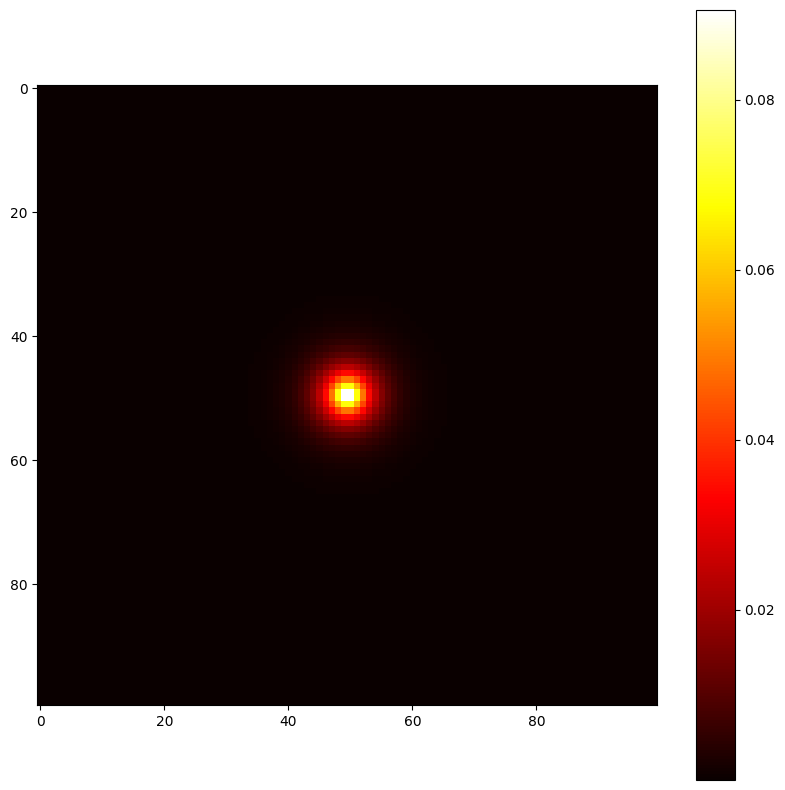

In [ ]:
def plot_wavefunction_2dslice(eigenvector, slice_index = N//2):
  # plot the wavefunction in 2D slices
  plt.figure(figsize=(10,10))
  plt.imshow(np.abs(eigenvector.reshape((N,N,N))[:,:,slice_index]), cmap='hot')
  plt.colorbar()
  plt.show()

plot_wavefunction_2dslice(min_vec)

Ok, so that's the ground state, but what about any of the other states? Well, back when we were considering $b^{(k)} = A^kb = \lambda_1^k x_1 + \lambda_2^k x_2 + \cdots + \lambda_n^k x_n$, if we were to just remove $x_1$ and any other eigenvectors we know, then the vector we would converge to would just be the one with the second largest eigenvalue, the first excited state.

But how do just remove a vector? We use a fairly standard vector operation called *projection* (or rather it's cousin, *rejection*) that can convert a vector $v_1$ into two vectors $v_1 = p + n$, where $p \parallel v_2$ and $n \perp v_2$ for a given vector $v_2$. Projection is taking $p$ as the result Rejection is taking $n$. It's fairly elementary, so I'll allow you to [look it up yourself](https://en.wikipedia.org/wiki/Vector_projection).

Since Hamiltonians are hermitian, the different eigenvectors are orthogonal to each other. So if we implement this rejection process at every step, then we remove the ground state (and any other states we have already found), and so we get the first excited state.

> Technically we could just apply rejection once in the beginning, since eigenvectors evolve into themselves when applying the matrix, but since we don't have the true eigenvectors and only their approximations, applying it at each step is better.

Also, when performing rejection using multiple orthogonal vectors, either you can do it in a single step ($b' = b - p_1 - p_2 - \cdots$), or in multiple steps ($b_1 = b - p_1(b), b_2 = b_1 - p_2(b_1), \cdots$). The multi-step approach is preferred as it is found to be numerically stable.

Ok, so now that you have understood the process, add an optional input variable `excluded_space` to the function `power_iteration`. It will be a list of vectors, like the `eigenvector_list` we have maintained so far (here it is a normal python list instead of numpy list because of memory reasons, but either works). Perform rejection using all the vectors after each iteration.

In [ ]:
for _ in range(4) :
    eig_val, eig_vec = power_iteration(hamiltonian, mu = max_e, max_iterations = 3000, excluded_space=eigenvector_list)
    eigenvalue_list.append(eig_val)
    eigenvector_list = np.vstack((eigenvector_list, eig_vec))

In [ ]:
eigenvalue_list

[1140.4867892844416,
 13.164935085674642,
 3.3582447426165345,
 2.1344998037334335,
 2.694380427626129,
 3.4117676983173624]

In [ ]:
print(np.dot(eigenvector_list[2], eigenvector_list[3]))
print(np.dot(eigenvector_list[2], eigenvector_list[4]))
print(np.dot(eigenvector_list[2], eigenvector_list[5]))

(3.885780586188048e-16+0j)
(4.440892098500626e-16+0j)
(-1.1102230246251565e-16+0j)


In [ ]:
import numpy as np

# Assuming eigenvectors_list is your list of eigenvectors
np.save('/content/eigenvectors.npy', eigenvector_list)
np.save('/content/eigenvalues.npy', eigenvalue_list)

from google.colab import files
files.download('/content/eigenvectors.npy')
files.download('/content/eigenvalues.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

eigenvector_list = np.load('/content/eigenvectors.npy')
eigenvalue_list = np.load('/content/eigenvalues.npy')

Good job! Now we simply plot and enjoy the fruit of our labor!

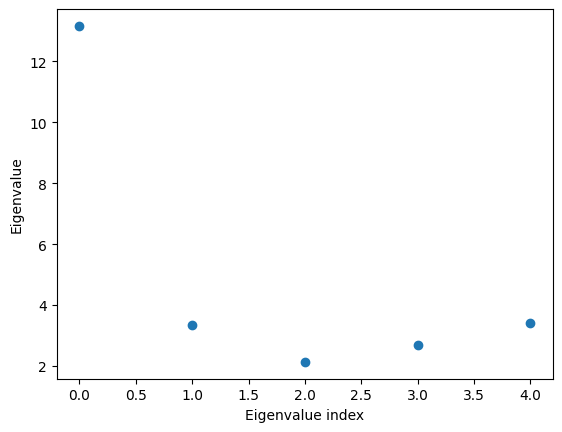

In [ ]:
# plot the eigenvalues
plt.plot([x.real for x in eigenvalue_list[1:]], 'o')
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')
plt.show()

As expected from ground state (1s) and first 4 excited states (1 from 2s and 3 from 2p)! Beautiful!

In [ ]:
#the ground state energy is the first eigenvalue
print('Ground state energy (calculated): ', min_e.real, 'eV')

#the true value of the ground state energy is -13.6 eV
print('Ground state energy (known): ', -13.6, 'eV')

Ground state energy (calculated):  13.164935085674642 eV
Ground state energy (known):  -13.6 eV


In [ ]:
def plot_wavefunction_2dslice(eigenvector, slice_index = N//2):
  # plot the wavefunction in 2D slices
  plt.figure(figsize=(10,10))
  plt.imshow(np.abs(eigenvector.reshape((N,N,N))[:,:,slice_index]), cmap='hot')
  plt.colorbar()
  plt.show()

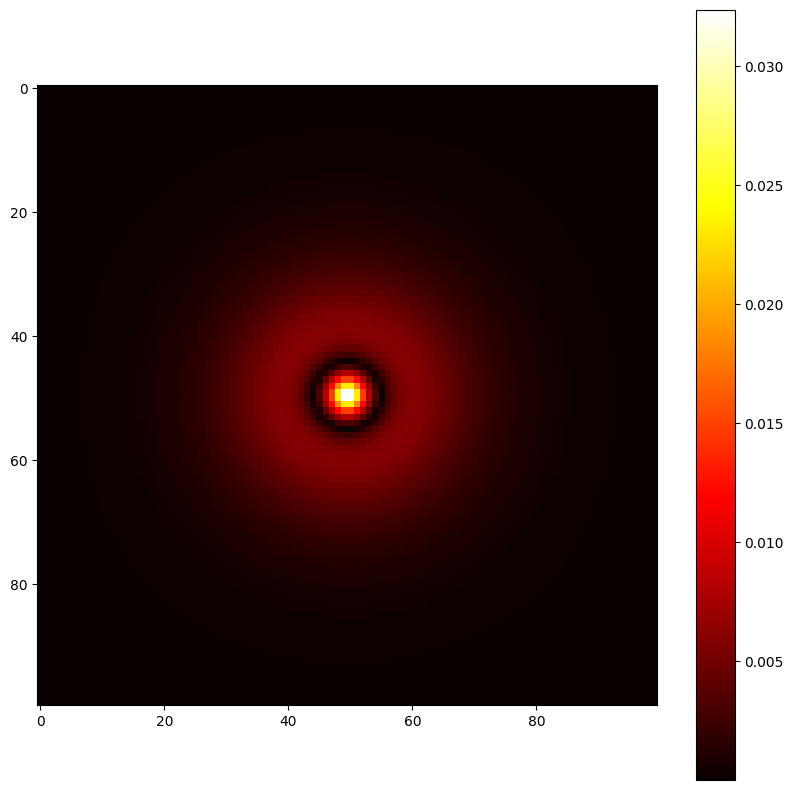

In [ ]:
plot_wavefunction_2dslice(eigenvector_list[2,:])

Now we plot all the 4 $n=2$ wave fucntions.

In [ ]:
def plot_all_probdensity_2dslice(eigenvectors, slice_index = N//2):
  # plot the wavefunction in 2D slices
  n = ceil(sqrt(len(eigenvectors)))
  plt.figure(figsize=(10,10))
  for i in range(len(eigenvectors)):
    plt.subplot(n,n,i+1)
    plt.imshow(np.abs(eigenvectors[i].reshape((N,N,N))[:,:,slice_index])**2, cmap='hot')
  plt.show()

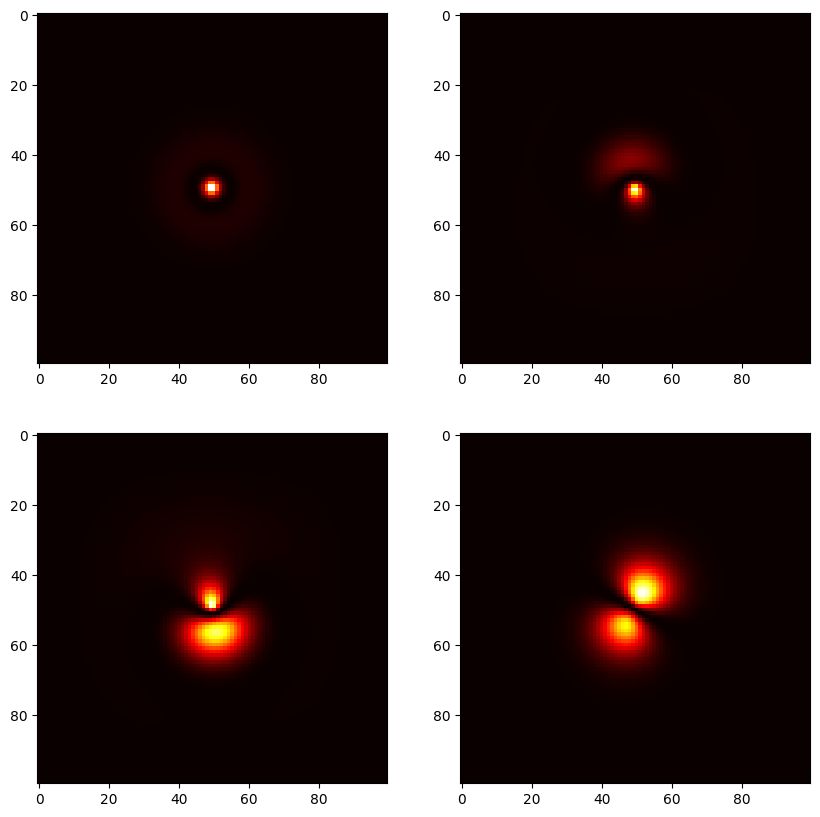

In [ ]:
plot_all_probdensity_2dslice(eigenvector_list[2:], )

As you can see, the wavefunctions (their probability density really, which we have plotted here) are not in the neat order or in the neat axis oriented forms we see in textbooks. This is because our algorithm has no way discriminating between degenerate states in a particular eigenspace. Thus we end up with arbitrary linear combinations of 2s and 2p orbitals.

Of course, there are better algorithms like Arnoldi iteration (a variant of which is used by `scipy.sparse.linalg.eigs`) which don't discard information from previous iterations and try to diagonalize in a reduced space called Krylov subspaces $= \operatorname{span}\left\{b, Ab, A^2b, \cdots A^kb \right\}$, but these are right now beyond the scope. Of course, the improvements are immense; `scipy.sparse.linalg.eigs` gives us 30 eigenvectors in less time than we took for 6. You can try it out.

# THE END